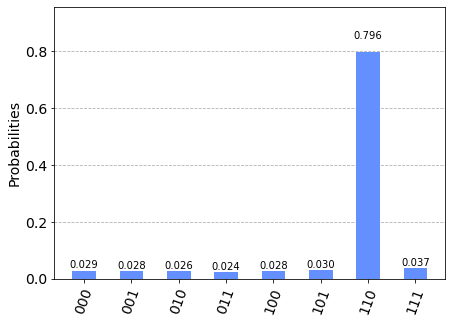

In [192]:
import numpy as np
import math
from qiskit import (
    QuantumCircuit,
    execute,
    Aer
)
from qiskit.quantum_info import Operator, average_gate_fidelity
import random
from qiskit.visualization import plot_histogram

# Sources https://www.youtube.com/watch?v=AabglvQSBR4 - Vazirani Grover
# Nielsen and Chuang chapter 6


n = 3
grover_circuit = QuantumCircuit(n)

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

grover_circuit = initialize_s(grover_circuit, [0,1,2])

#grover_circuit.z(0)
#grover_circuit.h(0)
grover_circuit.h(0)
grover_circuit.mct([1,2], 0)  # multi-controlled-toffoli for 0 in bit string 
grover_circuit.h(0)


#grover_circuit.x(0)
#grover_circuit.x(1)
#grover_circuit.x(2)

grover_circuit.barrier()

# Diffusion operator (U_s) - Inversion about the mean
grover_circuit.append(diffuser(n),[0,1,2])

grover_circuit.measure_all()

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)


In [191]:
grover_circuit.draw()


┌───┐┌───┐┌───┐┌───┐ ░ ┌──────┐ ░ ┌─┐      
   q_0: ┤ H ├┤ H ├┤ X ├┤ H ├─░─┤0     ├─░─┤M├──────
        ├───┤└───┘└─┬─┘└───┘ ░ │      │ ░ └╥┘┌─┐   
   q_1: ┤ H ├───────■────────░─┤1 U_s ├─░──╫─┤M├───
        ├───┤       │        ░ │      │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├───────■────────░─┤2     ├─░──╫──╫─┤M├
        └───┘                ░ └──────┘ ░  ║  ║ └╥┘
meas: 3/═══════════════════════════════════╩══╩══╩═
                                           0  1  2